In [15]:
import seawater as sw
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import glob
import importlib as imp
% matplotlib inline

In [16]:
from ArcticTools import detrend as detrd
from ArcticTools import map
from ArcticTools import hovmoller as hov
from ArcticTools import Topostrophy_sepecific_layer as Ts

In [17]:
Bathy=nc.Dataset('/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=Bathy.variables['Bathymetry'][400:,:500]


mesh=nc.Dataset('/ocean/xiaoxiny/research/data/mesh_mask_anha4_201509.nc')
tmask= mesh.variables['tmask'][0,:,400:,:500]
e3t = mesh.variables['e3t'][0,:,400:,:500]
dep = mesh.variables['gdept_0'][0.,:]
nav_lon=mesh.variables['nav_lon'][400:,:500]
nav_lat=mesh.variables['nav_lat'][400:,:500]

In [18]:
x=np.linspace(1,tmask.shape[2],tmask.shape[2])

In [19]:
isomask = np.zeros((13, tmask.shape[0],tmask.shape[1],tmask.shape[2]))
timestep = 0

#fig,axes = plt.subplots(4,3,figsize = (18,19))
for year in range (2002,2014):
        
        print ('>>> processing %s'%year)
        
        
        sal=  hov.load_ts('S',year,tmask, ENG='EXH001'.lower(), key = '_s_')[:,:,:500]
        temp=  hov.load_ts('T',year,tmask,ENG='EXH001'.lower(), key = '_t_')[:,:,:500]
        t = sw.library.T90conv(temp[:])
        rho = sw.dens0(sal, t)*tmask

    
        for j in range (rho.shape[1]):
            for k in range (rho.shape[2]):
                for i in range(rho.shape[0]):
                    if rho[i,j,k] >1027.8 and rho[i,j,k] <1028.05:
                        isomask[timestep,i,j,k] = 1
        # make simply plots. test function , monitor the trend  
        #ax = axes.flat[timestep]
        #ax.pcolor(x,dep,rho[:,250,:]*isomask[timestep,:,250,:],vmin=1027.8,vmax=1028.05)
        #ax.contour(x,dep,tmask[:,250,:],[0],colors='w')
        #ax.invert_yaxis()
        timestep +=1

>>> processing 2002


/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3248: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 2; dimension is 544 but corresponding boolean dimension is 500
  _data[indx] = dval
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3249: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 2; dimension is 544 but corresponding boolean dimension is 500
  _mask[indx] = mval
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:812: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


>>> processing 2003
>>> processing 2004
>>> processing 2005
>>> processing 2006
>>> processing 2007
>>> processing 2008
>>> processing 2009
>>> processing 2010
>>> processing 2011
>>> processing 2012
>>> processing 2013


In [20]:
rotation = nc.Dataset('/ocean/xiaoxiny/research/result_jasper/RotatedAngle_ANHA4.nc')
gsint = rotation.variables['gsint'][400:,:500]
gcost = rotation.variables['gcost'][400:,:500]

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in less
/home/xiaoxin

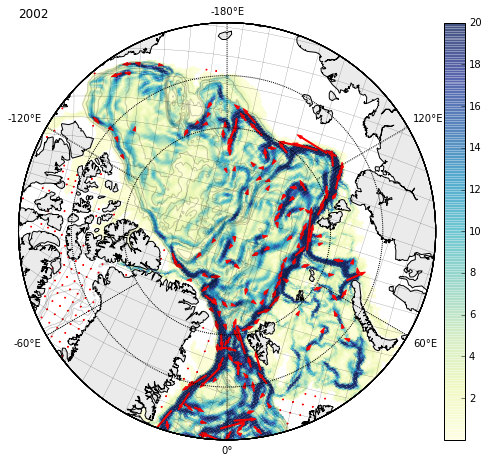

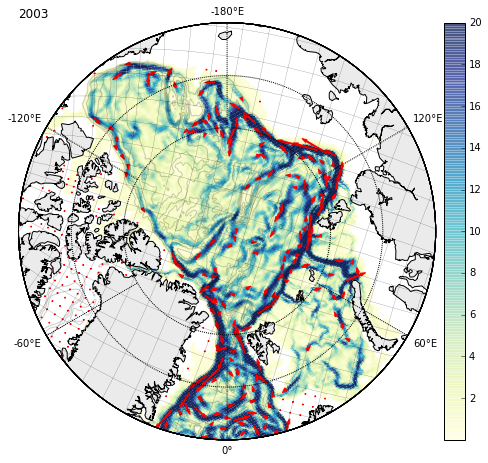

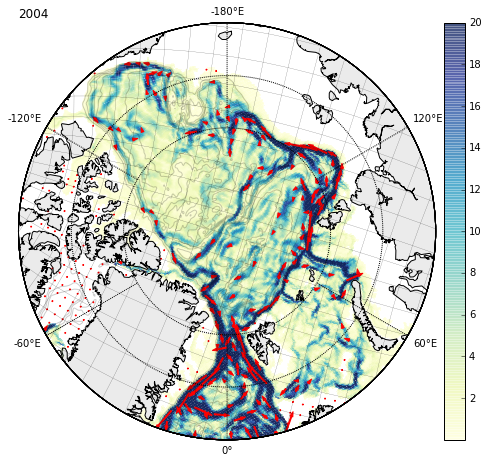

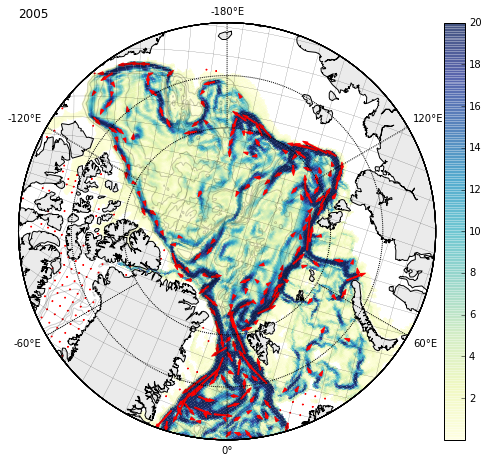

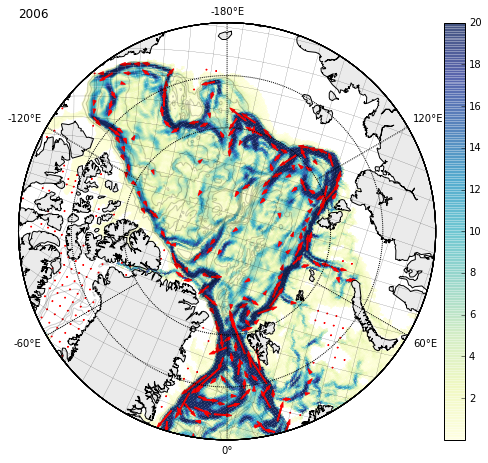

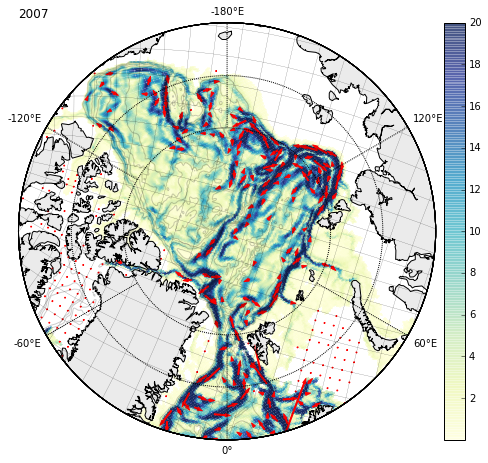

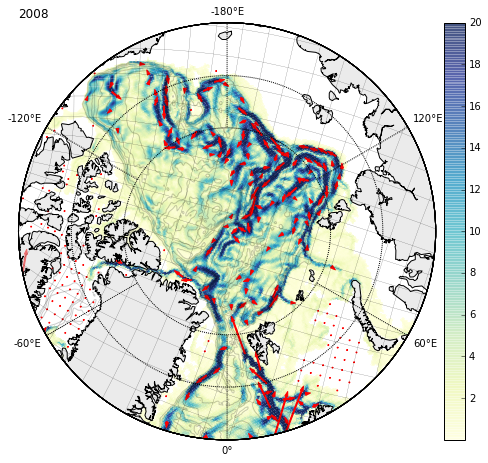

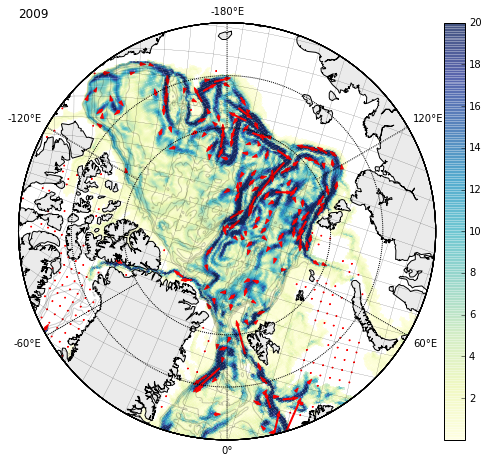

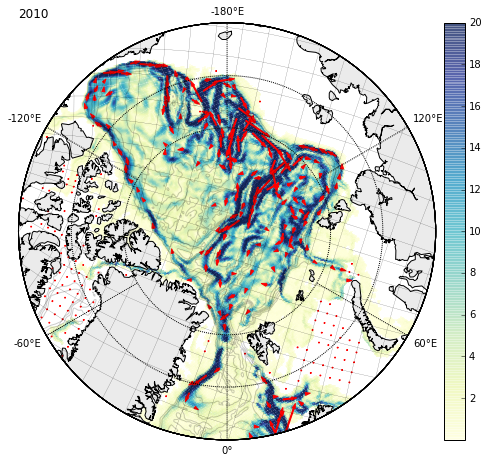

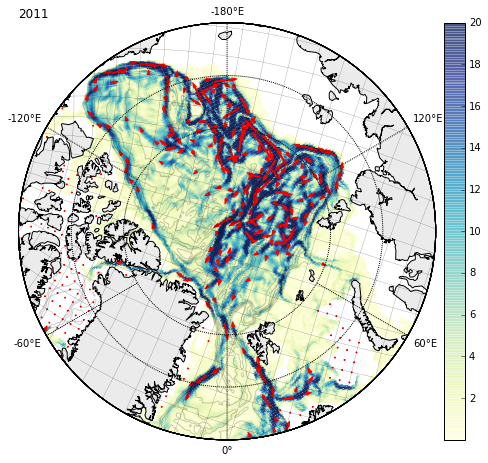

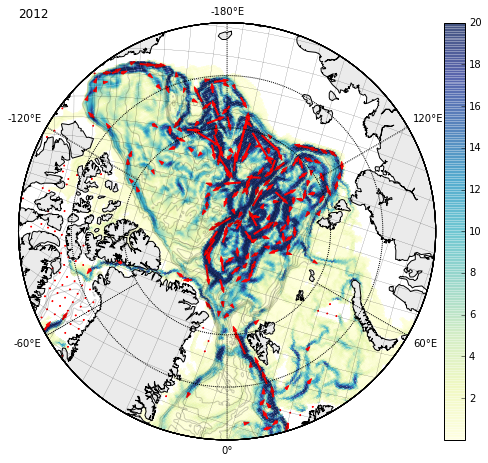

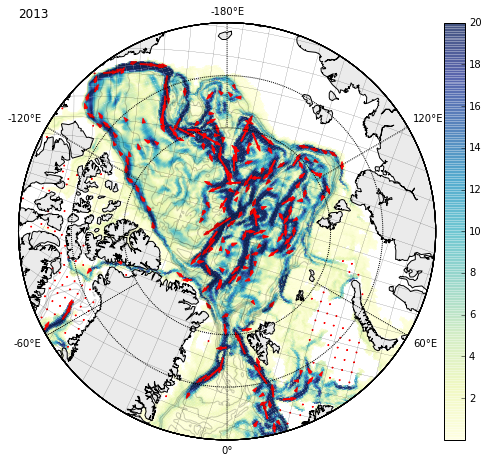

In [22]:
timestep = 0
# allocation
sumu = np.zeros((13, tmask.shape[1],tmask.shape[2]))
sumv = np.zeros((13, tmask.shape[1],tmask.shape[2]))

for i in range (2002,2014):
    tempu = Ts.load_v('U',i,'EXH001','U')[:,:,:500]
    tempv = Ts.load_v('V',i,'EXH001','V')[:,:,:500]
    tempu[tempu>10] = np.nan
    tempv[tempv>10] = np.nan

    tempu=np.nan_to_num(tempu)
    tempv=np.nan_to_num(tempv)


    tempu[:,:, 1:] = 0.5*(tempu[:,:, :-1] + tempu[:,:, 1:])
    tempv[:,1:, :] = 0.5*(tempv[:,:-1, :] + tempv[:,1:, :])

    tempu = tempu * isomask[timestep,...]
    tempv = tempv * isomask[timestep,...]


    for layer in range (50):
        sumu[timestep,...] += tempu[layer,...] * e3t[layer,...]
        sumv[timestep,...] += tempv[layer,...] * e3t[layer,...]


    U_mean = sumu[timestep,:,:]*gcost - sumv[timestep,:,:]*gsint
    V_mean = sumv[timestep,:,:]*gcost + sumu[timestep,:,:]*gsint

    fig = plt.figure(figsize=(8, 8))
    m, x0, y0 = map.mapping(70)

    uproj, vproj, x, y = m.rotate_vector(U_mean, V_mean, nav_lon, nav_lat, returnxy=True)
    sumU = (U_mean**2 + V_mean**2)**0.5
    sumU[sumU==0]=np.nan
    #sumU[:120,:]=np.nan

    m.pcolor(x,y,np.ma.masked_invalid(sumU),vmax=20,alpha =0.5, cmap = 'YlGnBu')
    m.colorbar()

    uproj[sumU<10] = np.nan
    vproj[sumU<10] = np.nan
    uproj[tmask[25,:,:]==0]=np.nan
    vproj[tmask[25,:,:]==0]=np.nan

    m.quiver(x[::8,::8], y[::8,::8], uproj[::8,::8], vproj[::8,::8],
            color='r', linewidths=1, edgecolors=('r'), headaxislength=5,scale = 980)

    plt.title(i,loc='left')
    plt.show()
    timestep +=1